In [1]:
library(dplyr)
library(ggplot2)
library(RcppRoll)
library(sqldf)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: gsubfn

Loading required package: proto

Warning message in doTryCatch(return(expr), name, parentenv, handler):
“unable to load shared object '/Library/Frameworks/R.framework/Resources/modules//R_X11.so':
  dlopen(/Library/Frameworks/R.framework/Resources/modules//R_X11.so, 6): Library not loaded: /opt/X11/lib/libSM.6.dylib
  Referenced from: /Library/Frameworks/R.framework/Versions/3.6/Resources/modules/R_X11.so
  Reason: image not found”
Could not load tcltk.  Will use slower R code instead.

Loading required package: RSQLite



In [2]:
# to get this data:
# git clone https://github.com/chadwickbureau/retrosplits

df = read.csv('data/retrosplits/daybyday/playing-1999.csv')
df$season = 1999

for (season_ in 1999:2019)
{
    filename = paste0('data/retrosplits/daybyday/playing-', as.character(season_), '.csv')
    df_new = read.csv(filename)
    df_new$season = season_
    df = rbind(df, df_new)

}

In [3]:
# we later define "expected woba" using previous and following seasons' woba. 
# exclude players without a previous and next season (rookies, retirees)
# use inner join this onto the game-level data once "expected woba" is calculated and added to the dataset
player_years = df %>% select(person.key, season) %>% mutate(next_year = season+1, previous_year=season-1) %>% distinct()
player_years_to_keep = player_years %>% inner_join(player_years, by=c("season"="previous_year", "person.key"="person.key"))
player_years_to_keep = player_years_to_keep %>% inner_join(player_years, by=c("season"="next_year", "person.key"="person.key"))

In [4]:
# limit to just regular season, define 1B events
df = df %>% filter(season.phase=='R')
df = df %>% mutate(B_1B = B_H - B_2B - B_3B - B_HR)

In [5]:
# define game number within the season. later we'll want to exclude the final five games from streak identification
game_nums = df %>% group_by(season, team.key) %>% distinct(game.date, game.key, team.key) %>% arrange(season, team.key, game.date) %>% 
    mutate(game_num = seq_along(game.date))

df = df %>% left_join(game_nums %>% ungroup() %>% select(game.key, team.key, game_num), by=c('game.key', 'team.key'))

# do this filter AFTER creating game numbers so the game number is still accurate
df = df %>% filter(team.key != 'COL', site.key != 'DEN02')

In [6]:
# create home/away flag by finding most common stadium for each team
home_stadiums = df %>% group_by(team.key, season) %>% count(site.key) %>% top_n(1)
df = df %>% left_join(home_stadiums, by=c('team.key', 'season'), 
                 suffix=c('', '_homeflag')) %>% 
    mutate(home_or_away = ifelse(site.key==site.key_homeflag, 'home', 'away'))

Selecting by n



In [7]:
# create component-level park effects
games = df %>% group_by(team.key, opponent.key, season, site.key, game.date, game.number, home_or_away) %>% 
                summarise(B_HR=sum(B_HR), 
                         B_1B = sum(B_1B),
                         B_2B = sum(B_2B),
                         B_3B = sum(B_3B),
                         B_BB = (sum(B_BB) - sum(B_IBB)),
                         B_HP = sum(B_HP),
                         B_XI = sum(B_XI),
                         B_R = sum(B_R),
                         games = n_distinct(team.key, opponent.key, season, 
                                            site.key, game.date, game.number, 
                                            home_or_away)) %>%
                ungroup() 

home = games %>% filter(home_or_away=='home') %>% 
    left_join(games, by=c("opponent.key"="team.key", "game.date"="game.date", 
                         "game.number"="game.number"),
             suffix=c("","_opponent"))  %>% 
    group_by(season, team.key) %>% 
                summarise(B_HR=(sum(B_HR, na.rm=TRUE) + sum(B_HR_opponent, na.rm=TRUE))/sum(games), 
                         B_1B = (sum(B_1B, na.rm=TRUE) + sum(B_1B_opponent, na.rm=TRUE))/sum(games), 
                         B_2B = (sum(B_2B, na.rm=TRUE) + sum(B_2B_opponent, na.rm=TRUE))/sum(games), 
                         B_3B = (sum(B_3B, na.rm=TRUE) + sum(B_3B_opponent, na.rm=TRUE))/sum(games), 
                         B_BB = (sum(B_BB, na.rm=TRUE) + sum(B_BB_opponent, na.rm=TRUE))/sum(games), 
                         B_HP = (sum(B_HP, na.rm=TRUE) + sum(B_HP_opponent, na.rm=TRUE))/sum(games), 
                         B_XI = 1, #(sum(B_XI, na.rm=TRUE) + sum(B_XI_opponent, na.rm=TRUE))/sum(games), 
                         B_R = (sum(B_R, na.rm=TRUE) + sum(B_R_opponent, na.rm=TRUE))/sum(games), 
                        games=sum(games)
                ) %>% ungroup()


away = games %>% filter(home_or_away=='away') %>% 
    left_join(games, by=c("opponent.key"="team.key", "game.date"="game.date", 
                         "game.number"="game.number"),
             suffix=c("","_opponent"))  %>% 
    group_by(season, team.key) %>% 
                summarise(B_HR = (sum(B_HR, na.rm=TRUE) + sum(B_HR_opponent, na.rm=TRUE))/sum(games), 
                         B_1B = (sum(B_1B, na.rm=TRUE) + sum(B_1B_opponent, na.rm=TRUE))/sum(games), 
                         B_2B = (sum(B_2B, na.rm=TRUE) + sum(B_2B_opponent, na.rm=TRUE))/sum(games), 
                         B_3B = (sum(B_3B, na.rm=TRUE) + sum(B_3B_opponent, na.rm=TRUE))/sum(games), 
                         B_BB = (sum(B_BB, na.rm=TRUE) + sum(B_BB_opponent, na.rm=TRUE))/sum(games), 
                         B_HP = (sum(B_HP, na.rm=TRUE) + sum(B_HP_opponent, na.rm=TRUE))/sum(games), 
                         B_XI = 1, #(sum(B_XI, na.rm=TRUE) + sum(B_XI_opponent, na.rm=TRUE))/sum(games), 
                         B_R = (sum(B_R, na.rm=TRUE) + sum(B_R_opponent, na.rm=TRUE))/sum(games))


park_effects = home %>% left_join(away, by=c('team.key', 'season'), suffix=c('', '_road')) %>%
    mutate(
      B_HR = B_HR/B_HR_road, 
      B_1B = B_1B/B_1B_road,
      B_2B = B_2B/B_2B_road,
      B_3B = B_3B/B_3B_road,
      B_BB = B_BB/B_BB_road,
      B_HP = B_HP/B_HP_road,
      B_XI = 1, # this one's doing more harm than good. too low volume to be helpful.
      B_R = B_R/B_R_road,
    )

# connect park effects with their site.key
park_effects = park_effects %>% left_join(home_stadiums, by=c('team.key', 'season')) %>%
    select(season, site.key, team.key, B_R, B_HR, B_1B,
          B_2B, B_3B, B_HP, B_XI, B_BB)

`summarise()` regrouping output by 'team.key', 'opponent.key', 'season', 'site.key', 'game.date', 'game.number' (override with `.groups` argument)

`summarise()` regrouping output by 'season' (override with `.groups` argument)

`summarise()` regrouping output by 'season' (override with `.groups` argument)



In [8]:
# park-adjust all events
df = df %>% left_join(park_effects, by=c('season', 'site.key'), suffix = c("", "_parkfactor"))

df = df %>% mutate(
     B_HR = B_HR / B_HR_parkfactor,
     B_1B = B_1B/B_1B_parkfactor,
     B_2B = B_2B/B_2B_parkfactor,
     B_3B = B_3B/B_3B_parkfactor,
     B_BB = B_BB/B_BB_parkfactor,
     B_HP = B_HP/B_HP_parkfactor,
     B_XI = B_XI/B_XI_parkfactor,
     B_R = B_R/B_R_parkfactor,
)

In [9]:
park_effects %>% filter(season==2010) %>% arrange(-B_R)

season,site.key,team.key,B_R,B_HR,B_1B,B_2B,B_3B,B_HP,B_XI,B_BB
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2010,CHI11,CHN,1.2021605,1.1412894,1.1135313,1.0828650,1.4444444,0.9629630,1,1.0112116
2010,NYC21,NYA,1.1767181,1.4203822,0.9779874,1.0592885,0.7037037,1.2881356,1,0.9600694
2010,CHI12,CHA,1.1348974,1.5447154,0.9171375,1.1240310,0.7826087,0.8833333,1,1.1833741
2010,BAL12,BAL,1.1117825,1.2624113,1.0805785,1.0071429,0.7096774,1.4042553,1,0.9931034
2010,BOS07,BOS,1.1028574,0.8749502,1.0428349,1.2195309,0.5644955,1.3962963,1,1.0256847
2010,ARL02,TEX,1.0907801,1.1600000,1.0596095,1.0653846,0.7692308,1.2978723,1,0.9900596
2010,TOR02,TOR,1.0513350,1.3547745,0.9859893,0.9298225,1.1250000,0.7988166,1,0.9843750
2010,PHO01,ARI,1.0247100,1.0264550,0.9638820,1.0240000,2.4052288,0.5982906,1,0.8851929
2010,CIN09,CIN,1.0125243,1.1307996,1.0301844,0.9335199,1.0370370,0.8103623,1,1.0128848


In [10]:
df = df %>% mutate(game.date = as.Date(game.date))

# Hot/cold streak definition

* Defined a hot / cold wOBA threshold 
* Rolling wOBA over five-game periods (so first or last five of the year cant be considered)
* Must have at least 20 PA in the five game stretch to be considered
* Thresholds defined as groups where 5 percent of league is hot, 5 is cold for a given 5 game stretch
* Roughly this means .525 woba for hot, .195 for cold 



TODO: make sure streaks don't count if a player missed a game in the middle. 

In [11]:
# define woba numerator and denominator to get N-game woba
# weights by year https://www.fangraphs.com/guts.aspx?type=cn
df = df %>% mutate(
    woba_numerator = 0.9*B_1B + 1.24*B_2B + 1.56*B_3B + 1.95*B_HR + 0.72*(B_BB - B_IBB) + 0.75*B_HP +  0.92*B_XI, # the book's weights
    woba_denominator = B_PA,
    game_woba = woba_numerator / woba_denominator)

In [12]:
# SQL query to create players' expected woba
# expected woba: a player's woba from the current, previous, and following season, omitting the player's past 5 games (inclusive of the current game)
player_woba = sqldf('
      select 
        df1."person.key",
        df1.season,
        df1.game_num,
        SUM(coalesce(df2.woba_numerator, 0)) season_woba_num,
        SUM(coalesce(df2.woba_denominator, 0)) season_woba_denom,
        sum(coalesce(df2.woba_numerator, 0))/sum(coalesce(df2.woba_denominator, 0)) expected_woba,
        sum(df2.B_PA) season_pa
      from
        df AS df1
      left join
        (select "person.key", season, game_num, SUM(coalesce(woba_numerator, 0)) woba_numerator,
    SUM(coalesce(woba_denominator, 0)) woba_denominator, sum(B_PA) B_PA from df group by 1,2,3) AS df2
      ON
        df1."person.key" = df2."person.key"
      AND
        df1.season <= df2.season + 1
      AND
        df1.season >= df2.season - 1
      AND
        (
            (df1.season*1000 + df1.game_num) <= (df2.season*1000 + df2.game_num -7)
        OR
            (df1.season*1000 + df1.game_num) > (df2.season*1000 + df2.game_num)
        )
      GROUP BY df1."person.key", df1.season, df1.game_num
')

In [13]:
player_woba %>% filter(season_pa>50) %>% arrange(-expected_woba) %>% head(15)

,person.key,season,game_num,season_woba_num,season_woba_denom,expected_woba,season_pa
,<fct>,<dbl>,<int>,<dbl>,<int>,<dbl>,<int>
1,bondb001,2001,2,974.9469,1742,0.5596710,1742
2,bondb001,2001,1,970.9338,1737,0.5589717,1737
3,bondb001,2001,3,973.9206,1743,0.5587611,1743
4,bondb001,2001,4,971.1922,1742,0.5575156,1742
5,bondb001,2001,73,966.8665,1736,0.5569507,1736
6,bondb001,2001,87,966.0794,1736,0.5564973,1736
7,bondb001,2001,71,968.2493,1740,0.5564651,1740
8,bondb001,2001,77,969.0023,1742,0.5562585,1742
9,bondb001,2001,88,965.0979,1735,0.5562524,1735


In [14]:
df = df %>% left_join(player_woba,by=c('season', 'person.key', 'game_num'))

# remove these seasons. no future/past season available for calculating their expected woba values
df = df %>% filter(season > 1999, season < 2019)

dim(df)
# remove players we can't calculate an expected woba for 
df = df %>% inner_join(player_years_to_keep, by=c("person.key", "season"), suffixes=c("", "_ignore"))
dim(df)

[1] 1251409     197

[1] 1008701     203

In [15]:
# take rolling sums of woba components to get a 5g woba
library(zoo)
num_games_streak = 5
num_games_post_streak = 5
min_pa_in_streak = 4 * num_games_streak #4
min_pa_post_streak = 3 * num_games_post_streak #0
# different offset used for post streak folling counts for 3 vs. 5 game configuration. paste this in if changing streak lenghts.
seven_game_post = list(c(1, 2, 3,4,5,6,7))
five_game_post = list(c(1, 2, 3, 4, 5))

# this is ugly indentation but makes it ahrder to forget to paste something when updating it
df = df %>%
         arrange(season, person.key, game.date, game.key) %>%
         group_by(season, person.key) %>%
         mutate(woba_num_rolling =   roll_sum(woba_numerator, num_games_streak, align = "right", fill = NA),
                pa_rolling =         roll_sum(B_PA, num_games_streak, align = "right", fill = NA),
                woba_denom_rolling = roll_sum(woba_denominator, num_games_streak, align = "right", fill = NA),
                woba_rolling = woba_num_rolling/woba_denom_rolling,
                woba_num_rolling_future =   rollapply(woba_numerator, FUN=sum, five_game_post, align = "left", fill = NA),
                pa_rolling_future =         rollapply(B_PA, FUN=sum, five_game_post, align = "left", fill = NA),
                woba_denom_rolling_future = rollapply(woba_denominator, FUN=sum,  five_game_post, align = "left", fill = NA),
                woba_rolling_future = woba_num_rolling_future/woba_denom_rolling_future,
                
                woba_num_rolling_future_nextgame =   rollapply(woba_numerator, FUN=sum, list(c(1)), align = "left", fill = NA),
                woba_denom_rolling_future_nextgame  = rollapply(woba_denominator, FUN=sum,  list(c(1)), align = "left", fill = NA),
                woba_rolling_future_nextgame  = woba_num_rolling_future_nextgame /woba_denom_rolling_future_nextgame 
        ) 


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric




## Get Thresholds for Hot/Cold Streaks (top/bottom 5% of league in x-game rolling wOBA)

In [16]:
# get seasons' percentiles for woba thresholds
df %>% 
    # only consider periods with at least 20 pa in them 
    filter(pa_rolling >= min_pa_in_streak, pa_rolling_future >= min_pa_post_streak) %>% 
    group_by(season, person.key, game.key) %>% summarise(woba = sum(woba_numerator) / sum(woba_denominator),
                                                  #woba_rolling_avg = mean(woba_rolling, na.rm=TRUE), 
                                                  woba_rolling_avg = sum(woba_num_rolling, na.rm=TRUE)/sum(woba_denom_rolling, na.rm=TRUE),
                                                  pa = sum(B_PA)) %>%
    ungroup() %>%
    summarise(thresholds = quantile(woba_rolling_avg, probs = c(0.05, 0.95))) 

`summarise()` regrouping output by 'season', 'person.key' (override with `.groups` argument)



thresholds
<dbl>
0.1649908
0.5574652


In [17]:
# create is hot/cold flags
hot_threshold = .557
cold_threshold = .165
df = df %>% ungroup() %>% 
    mutate(is_hot = ifelse(((woba_rolling > hot_threshold) & (pa_rolling>=min_pa_in_streak) & (game_num < 157)), 1, 0),
           is_cold = ifelse(((woba_rolling < cold_threshold) & (pa_rolling>=min_pa_in_streak) & (game_num < 157)), 1, 0))

## Calculate Streak, Post-Streak, and Expected Value Summary Stats

In [18]:
df %>% ungroup() %>%
    filter(is_hot==1,
          !is.na(woba_rolling_future)) %>%
    #group_by(season) %>%
    mutate(weighted_woba_num=B_PA*season_woba_num,
          weighted_woba_denom=B_PA*season_woba_denom) %>%
    summarise(
        unique_hot_players = n_distinct(person.key),
        total_hot_streaks = sum(is_hot),
        total_hot_pa = sum(pa_rolling),
        mean_hot_woba = sum(woba_num_rolling, na.rm=TRUE)/sum(woba_denom_rolling, na.rm=TRUE),
        mean_post_hot_woba_nextgame = sum(woba_num_rolling_future_nextgame, na.rm=TRUE)/sum(woba_denom_rolling_future_nextgame, na.rm=TRUE),
        mean_post_hot_woba = sum(woba_num_rolling_future, na.rm=TRUE)/sum(woba_denom_rolling_future, na.rm=TRUE),
        expected_woba= mean(expected_woba, na.rm=TRUE),
        std_mean_post_hot_woba = 1.96 * (sd(woba_num_rolling_future/woba_denom_rolling_future, na.rm=TRUE) / sqrt(n())),
        upper_ci_post = mean_post_hot_woba + std_mean_post_hot_woba,
        lower_ci_post = mean_post_hot_woba - std_mean_post_hot_woba,
        mean_season_woba = sum(season_woba_num) / sum(season_woba_denom)
    )

df %>% ungroup() %>%
    filter(is_cold==1,
          !is.na(woba_rolling_future)) %>%
    mutate(weighted_woba_num=B_PA*season_woba_num,
          weighted_woba_denom=B_PA*season_woba_denom) %>%
    summarise(
        unique_hot_players = n_distinct(person.key),
        total_hot_streaks = sum(is_cold),
        total_hot_pa = sum(pa_rolling),
        mean_hot_woba = sum(woba_num_rolling, na.rm=TRUE)/sum(woba_denom_rolling, na.rm=TRUE),
        mean_post_hot_woba_nextgame = sum(woba_num_rolling_future_nextgame, na.rm=TRUE)/sum(woba_denom_rolling_future_nextgame, na.rm=TRUE),
        mean_post_hot_woba = sum(woba_num_rolling_future, na.rm=TRUE)/sum(woba_denom_rolling_future, na.rm=TRUE),
        expected_woba= mean(expected_woba, na.rm=TRUE),
        std_mean_post_hot_woba = 1.96 * (sd(woba_num_rolling_future/woba_denom_rolling_future, na.rm=TRUE) / sqrt(n())),
        upper_ci_post = mean_post_hot_woba + std_mean_post_hot_woba,
        lower_ci_post = mean_post_hot_woba - std_mean_post_hot_woba,
        mean_season_woba = sum(season_woba_num) / sum(season_woba_denom)
    )


unique_hot_players,total_hot_streaks,total_hot_pa,mean_hot_woba,mean_post_hot_woba_nextgame,mean_post_hot_woba,expected_woba,std_mean_post_hot_woba,upper_ci_post,lower_ci_post,mean_season_woba
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
939,18677,410854,0.6211379,0.3654315,0.3646442,0.3627619,0.001855077,0.3664993,0.3627891,0.3666686


unique_hot_players,total_hot_streaks,total_hot_pa,mean_hot_woba,mean_post_hot_woba_nextgame,mean_post_hot_woba,expected_woba,std_mean_post_hot_woba,upper_ci_post,lower_ci_post,mean_season_woba
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1112,17945,383635,0.1279419,0.3284657,0.3306834,0.3291447,0.001796742,0.3324801,0.3288866,0.3334166


In [19]:
# table of example streaks for the blog post
df %>% ungroup() %>%
    filter(is_hot==1,
           season==2018,
          !is.na(woba_rolling_future)) %>%
    select(person.key, game.date, pa_rolling, woba_rolling, woba_rolling_future, expected_woba) %>% 
    arrange(-woba_rolling) %>% head(10)

# table of example streaks for the blog post
df %>% ungroup() %>%
    filter(is_cold==1,
           season==2018,
          !is.na(woba_rolling_future)) %>%
    select(person.key, game.date, pa_rolling, woba_rolling, woba_rolling_future, expected_woba) %>% 
    arrange(woba_rolling) %>% head(10)

person.key,game.date,pa_rolling,woba_rolling,woba_rolling_future,expected_woba
<fct>,<date>,<dbl>,<dbl>,<dbl>,<dbl>
carpm002,2018-07-21,20,0.9175632,0.2468486,0.3717219
carpm002,2018-07-21,22,0.8790695,0.3621136,0.3716158
davik003,2018-08-22,21,0.8642227,0.1652680,0.3516882
puigy001,2018-09-16,20,0.8608499,0.4483475,0.3592604
markn001,2018-05-05,22,0.8338275,0.3437795,0.3405135
troum001,2018-05-06,25,0.8331473,0.3308006,0.4413138
carpm002,2018-07-20,22,0.8301929,0.3967739,0.3672624
brega001,2018-09-07,21,0.8233951,0.3406034,0.4017841
davik003,2018-08-23,22,0.8229716,0.1154410,0.3524494


person.key,game.date,pa_rolling,woba_rolling,woba_rolling_future,expected_woba
<fct>,<date>,<dbl>,<dbl>,<dbl>,<dbl>
morak001,2018-05-06,22,0.00000000,0.26912012,0.3216176
gricr001,2018-04-08,20,0.00000000,0.38736826,0.3276326
gregd001,2018-05-10,23,0.02364018,0.06090538,0.3349252
gregd001,2018-05-11,22,0.02471473,0.10416311,0.3337782
jay-j001,2018-06-28,20,0.02756611,0.08298362,0.3151442
calhk001,2018-09-15,21,0.03430663,0.15668293,0.3180786
polla001,2018-09-01,22,0.03491230,0.33868010,0.3445051
martl004,2018-05-22,21,0.03738931,0.30083300,0.2946924
deshd002,2018-07-10,20,0.03810280,0.06260472,0.2782422


In [20]:
# t-test for significance
test = df %>% ungroup() %>%
    filter(is_hot==1,
          !is.na(woba_rolling_future)) %>%
    group_by(person.key,game.key) %>%
    summarise(
        total_hot_pa = sum(pa_rolling),
        post_hot_pa= sum(pa_rolling_future),
        mean_post_hot_woba = sum(woba_num_rolling_future, na.rm=TRUE)/sum(woba_denom_rolling_future, na.rm=TRUE),
        expected_woba= mean(expected_woba, na.rm=TRUE)
    )

test = test %>% filter(!is.na(mean_post_hot_woba),
                        post_hot_pa>=10)

t.test(test$mean_post_hot_woba, test$expected_woba)

test = df %>% ungroup() %>%
    filter(is_cold==1,
          !is.na(woba_rolling_future)) %>%
    group_by(person.key,game.key) %>%
    summarise(
        total_hot_pa = sum(pa_rolling),
        post_hot_pa= sum(pa_rolling_future),
        mean_post_hot_woba = sum(woba_num_rolling_future, na.rm=TRUE)/sum(woba_denom_rolling_future, na.rm=TRUE),
        expected_woba= mean(expected_woba, na.rm=TRUE)
    )

test = test %>% filter(!is.na(mean_post_hot_woba),
                        post_hot_pa>=10)
t.test(test$mean_post_hot_woba, test$expected_woba)

`summarise()` regrouping output by 'person.key' (override with `.groups` argument)




	Welch Two Sample t-test

data:  test$mean_post_hot_woba and test$expected_woba
t = -0.3204, df = 21894, p-value = 0.7487
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.002251144  0.001618582
sample estimates:
mean of x mean of y 
0.3624574 0.3627737 


`summarise()` regrouping output by 'person.key' (override with `.groups` argument)




	Welch Two Sample t-test

data:  test$mean_post_hot_woba and test$expected_woba
t = -1.6712, df = 20184, p-value = 0.09469
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.0034278412  0.0002726514
sample estimates:
mean of x mean of y 
0.3277402 0.3293178 


In [21]:
# regression for hot/cold effects
summary(lm(woba_rolling_future ~ expected_woba + is_hot + is_cold + site.key, 
           df %>% filter(!is.na(woba_rolling_future),
                        !is.na(is_hot))))


Call:
lm(formula = woba_rolling_future ~ expected_woba + is_hot + is_cold + 
    site.key, data = df %>% filter(!is.na(woba_rolling_future), 
    !is.na(is_hot)))

Residuals:
     Min       1Q   Median       3Q      Max 
-1.19543 -0.08918 -0.00808  0.08014  2.32976 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)    0.0276692  0.0011978  23.101  < 2e-16 ***
expected_woba  0.9058691  0.0026212 345.587  < 2e-16 ***
is_hot         0.0053390  0.0009981   5.349 8.85e-08 ***
is_cold        0.0009345  0.0010114   0.924  0.35555    
site.keyARL02 -0.0003046  0.0012099  -0.252  0.80119    
site.keyATL02  0.0009575  0.0012324   0.777  0.43720    
site.keyBAL12 -0.0007751  0.0012118  -0.640  0.52239    
site.keyBOS07 -0.0021901  0.0011891  -1.842  0.06550 .  
site.keyCHI11  0.0004740  0.0011835   0.401  0.68877    
site.keyCHI12 -0.0022895  0.0011971  -1.913  0.05580 .  
site.keyCIN08  0.0039646  0.0021711   1.826  0.06783 .  
site.keyCLE08  0.0001624  0.00119

Warning message:
“Removed 125 rows containing non-finite values (stat_bin).”


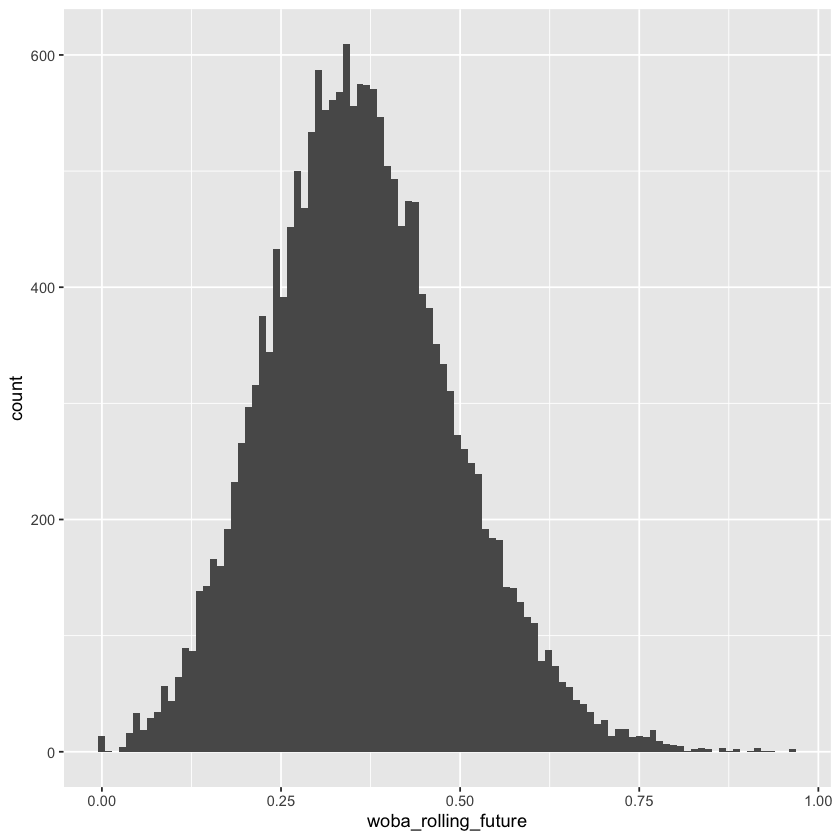

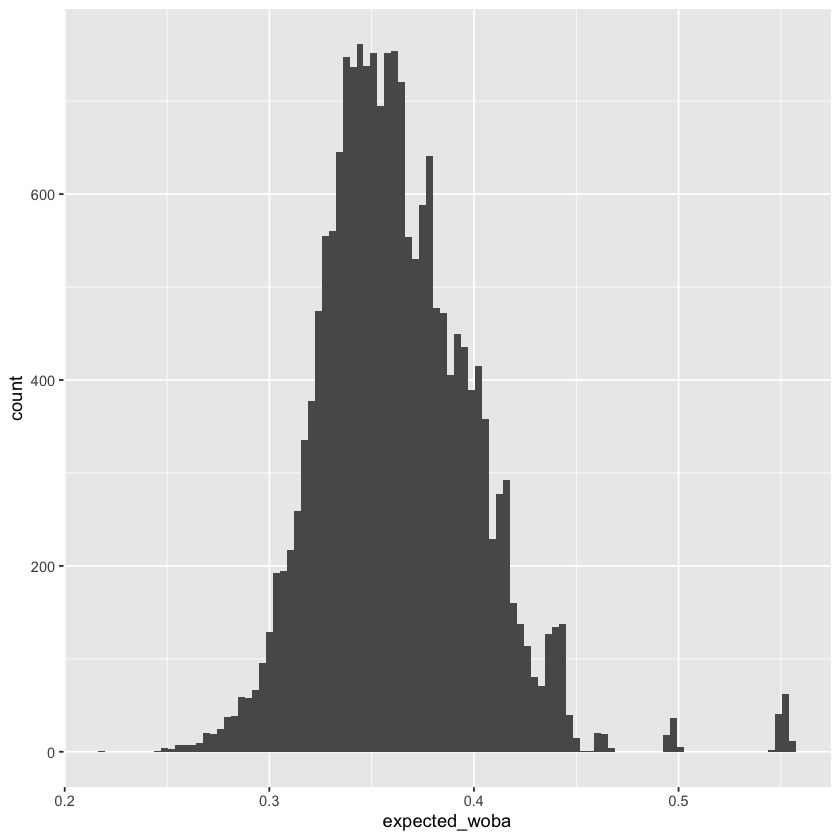

In [22]:
# inspect distributions of post-streak and expected woba
df %>% filter(is_hot==1) %>%
select(game.date, person.key, woba_rolling, 
       woba_rolling_future, expected_woba, 
       pa_rolling, pa_rolling_future,
      ) %>% 
select(woba_rolling_future) %>% ggplot(aes(x=woba_rolling_future)) + geom_histogram(bins=100)

df %>% filter(is_hot==1) %>%
select(game.date, person.key, woba_rolling, 
       woba_rolling_future, expected_woba, 
       pa_rolling, pa_rolling_future,
      ) %>% 
select(expected_woba) %>% ggplot(aes(x=expected_woba)) + geom_histogram(bins=100)

## Repeat the above steps for 7-game streaks

In [23]:
# take rolling sums of woba components to get a 5g woba
library(zoo)
num_games_streak = 7
num_games_post_streak = 3
min_pa_in_streak = 4 * num_games_streak #4
min_pa_post_streak = 3 * num_games_post_streak #0
# different offset used for post streak folling counts for 3 vs. 5 game configuration. paste this in if changing streak lenghts.
seven_game_post = list(c(1, 2, 3, 4, 5, 6, 7)) #list(c(1, 2, 3))
five_game_post = list(c(1, 2, 3, 4, 5))

# this is ugly indentation but makes it ahrder to forget to paste something when updating it
df = df %>%
         arrange(season, person.key, game.date, game.key) %>%
         group_by(season, person.key) %>%
         mutate(woba_num_rolling =   roll_sum(woba_numerator, num_games_streak, align = "right", fill = NA),
                pa_rolling =         roll_sum(B_PA, num_games_streak, align = "right", fill = NA),
                woba_denom_rolling = roll_sum(woba_denominator, num_games_streak, align = "right", fill = NA),
                woba_rolling = woba_num_rolling/woba_denom_rolling,
                woba_num_rolling_future =   rollapply(woba_numerator, FUN=sum, seven_game_post, align = "left", fill = NA),
                pa_rolling_future =         rollapply(B_PA, FUN=sum, seven_game_post, align = "left", fill = NA),
                woba_denom_rolling_future = rollapply(woba_denominator, FUN=sum,  seven_game_post, align = "left", fill = NA),
                woba_rolling_future = woba_num_rolling_future/woba_denom_rolling_future,
                
                woba_num_rolling_future_nextgame =   rollapply(woba_numerator, FUN=sum, list(c(1)), align = "left", fill = NA),
                woba_denom_rolling_future_nextgame  = rollapply(woba_denominator, FUN=sum,  list(c(1)), align = "left", fill = NA),
                woba_rolling_future_nextgame  = woba_num_rolling_future_nextgame /woba_denom_rolling_future_nextgame 
        ) 

In [24]:
# get seasons' quantiles for woba thresholds
#temp = df %>% group_by(season, person.key) %>% filter(sum(B_PA)>100) %>% ungroup()
df %>% 
    # only consider periods with at least 20 pa in them 
    filter(pa_rolling >= min_pa_in_streak, pa_rolling_future >= min_pa_post_streak) %>% 
    group_by(season, person.key, game.key) %>% summarise(woba = sum(woba_numerator) / sum(woba_denominator),
                                                  woba_rolling_avg = sum(woba_num_rolling, na.rm=TRUE)/sum(woba_denom_rolling, na.rm=TRUE),
                                                  pa = sum(B_PA)) %>%
    ungroup() %>%
    summarise(thresholds = quantile(woba_rolling_avg, probs = c(0.05, 0.95), na.rm=TRUE)) 

`summarise()` regrouping output by 'season', 'person.key' (override with `.groups` argument)



thresholds
<dbl>
0.1888272
0.5269443


In [25]:
# create is hot/cold flags
hot_threshold = .527
cold_threshold = .188
df = df %>% ungroup() %>% 
    mutate(is_hot = ifelse(((woba_rolling > hot_threshold) & (pa_rolling>=min_pa_in_streak) & (game_num < 157)), 1, 0),
           is_cold = ifelse(((woba_rolling < cold_threshold) & (pa_rolling>=min_pa_in_streak) & (game_num < 157)), 1, 0))

In [26]:
df %>% ungroup() %>%
    filter(is_hot==1,
          !is.na(woba_rolling_future)) %>%
    summarise(
        unique_hot_players = n_distinct(person.key),
        total_hot_streaks = sum(is_hot),
        total_hot_pa = sum(pa_rolling),
        mean_hot_woba = sum(woba_num_rolling, na.rm=TRUE)/sum(woba_denom_rolling, na.rm=TRUE),
        mean_post_hot_woba = sum(woba_num_rolling_future, na.rm=TRUE)/sum(woba_denom_rolling_future, na.rm=TRUE),
        mean_post_hot_woba_nextgame = sum(woba_num_rolling_future_nextgame, na.rm=TRUE)/sum(woba_denom_rolling_future_nextgame, na.rm=TRUE),
        std_mean_post_hot_woba = 1.96 * (sd(woba_num_rolling_future/woba_denom_rolling_future, na.rm=TRUE) / sqrt(n())),
        upper_ci_post = mean_post_hot_woba + std_mean_post_hot_woba,
        lower_ci_post = mean_post_hot_woba - std_mean_post_hot_woba,
        expected_woba= mean(expected_woba, na.rm=TRUE)
    )

df %>% ungroup() %>%
    filter(is_cold==1,
          !is.na(woba_rolling_future)) %>%
    summarise(
        unique_hot_players = n_distinct(person.key),
        total_hot_streaks = sum(is_cold),
        total_hot_pa = sum(pa_rolling),
        mean_hot_woba = sum(woba_num_rolling, na.rm=TRUE)/sum(woba_denom_rolling, na.rm=TRUE),
        mean_post_hot_woba = sum(woba_num_rolling_future, na.rm=TRUE)/sum(woba_denom_rolling_future, na.rm=TRUE),
        mean_post_hot_woba_nextgame = sum(woba_num_rolling_future_nextgame, na.rm=TRUE)/sum(woba_denom_rolling_future_nextgame, na.rm=TRUE),
        std_mean_post_hot_woba = 1.96 * (sd(woba_num_rolling_future/woba_denom_rolling_future, na.rm=TRUE) / sqrt(n())),
        upper_ci_post = mean_post_hot_woba + std_mean_post_hot_woba,
        lower_ci_post = mean_post_hot_woba - std_mean_post_hot_woba,
        expected_woba= mean(expected_woba, na.rm=TRUE)
    )

unique_hot_players,total_hot_streaks,total_hot_pa,mean_hot_woba,mean_post_hot_woba,mean_post_hot_woba_nextgame,std_mean_post_hot_woba,upper_ci_post,lower_ci_post,expected_woba
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
844,17623,540799,0.5806544,0.3695887,0.3681323,0.001643892,0.3712325,0.3679448,0.3673373


unique_hot_players,total_hot_streaks,total_hot_pa,mean_hot_woba,mean_post_hot_woba,mean_post_hot_woba_nextgame,std_mean_post_hot_woba,upper_ci_post,lower_ci_post,expected_woba
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1023,15790,471732,0.1559712,0.3284434,0.3267725,0.001622202,0.3300656,0.3268212,0.3273626


In [27]:
test = df %>% ungroup() %>%
    filter(is_hot==1,
          !is.na(woba_rolling_future)) %>%
    group_by(person.key,game.key) %>%
    summarise(
        total_hot_pa = sum(pa_rolling),
        post_hot_pa= sum(pa_rolling_future),
        mean_post_hot_woba = sum(woba_num_rolling_future, na.rm=TRUE)/sum(woba_denom_rolling_future, na.rm=TRUE),
        expected_woba= mean(expected_woba, na.rm=TRUE)
    )

test = test %>% filter(!is.na(mean_post_hot_woba),
                        post_hot_pa>=10)

t.test(test$mean_post_hot_woba, test$expected_woba)

test = df %>% ungroup() %>%
    filter(is_cold==1,
          !is.na(woba_rolling_future)) %>%
    group_by(person.key,game.key) %>%
    summarise(
        total_hot_pa = sum(pa_rolling),
        post_hot_pa= sum(pa_rolling_future),
        mean_post_hot_woba = sum(woba_num_rolling_future, na.rm=TRUE)/sum(woba_denom_rolling_future, na.rm=TRUE),
        expected_woba= mean(expected_woba, na.rm=TRUE)
    )

test = test %>% filter(!is.na(mean_post_hot_woba),
                        post_hot_pa>=10)
t.test(test$mean_post_hot_woba, test$expected_woba)

`summarise()` regrouping output by 'person.key' (override with `.groups` argument)




	Welch Two Sample t-test

data:  test$mean_post_hot_woba and test$expected_woba
t = 0.56946, df = 21717, p-value = 0.569
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.001233157  0.002243132
sample estimates:
mean of x mean of y 
0.3678469 0.3673419 


`summarise()` regrouping output by 'person.key' (override with `.groups` argument)




	Welch Two Sample t-test

data:  test$mean_post_hot_woba and test$expected_woba
t = -2.2761, df = 18496, p-value = 0.02285
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.0036528202 -0.0002724862
sample estimates:
mean of x mean of y 
0.3254375 0.3274002 


In [28]:
summary(lm(woba_rolling_future ~ expected_woba + is_hot + is_cold + site.key, 
           df %>% filter(!is.na(woba_rolling_future),
                        !is.na(is_hot), season_pa>50)))


Call:
lm(formula = woba_rolling_future ~ expected_woba + is_hot + is_cold + 
    site.key, data = df %>% filter(!is.na(woba_rolling_future), 
    !is.na(is_hot), season_pa > 50))

Residuals:
     Min       1Q   Median       3Q      Max 
-0.40145 -0.07400 -0.00462  0.06856  2.33057 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)    0.0196488  0.0011655  16.858  < 2e-16 ***
expected_woba  0.9341388  0.0028168 331.629  < 2e-16 ***
is_hot         0.0041550  0.0008445   4.920 8.65e-07 ***
is_cold       -0.0005792  0.0008820  -0.657  0.51135    
site.keyARL02  0.0002783  0.0010228   0.272  0.78554    
site.keyATL02  0.0012238  0.0010464   1.169  0.24220    
site.keyBAL12 -0.0004509  0.0010247  -0.440  0.65990    
site.keyBOS07 -0.0022334  0.0010019  -2.229  0.02581 *  
site.keyCHI11  0.0019490  0.0010033   1.943  0.05206 .  
site.keyCHI12 -0.0016583  0.0010103  -1.641  0.10072    
site.keyCIN08  0.0005644  0.0018640   0.303  0.76205    
site.keyCLE08  0.